# Imports
perform necessary imports and preparation

In [8]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
import numpy as np

from torchviz import make_dot
from tqdm import tqdm

import matplotlib.pyplot as plt

from skindataset import SkinDataset
from skindiffuser import NoiseScheduler, SkinUnet
from util import HParams

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Notebook is running on device: {device}')

Notebook is running on device: cuda


For easier tuning and experimentation regarding hyperparameters, we outsource them into a json file. The following utility class loads the values and makes the accessible to the code

In [9]:
hparams = HParams()
hparams

{'T': 600, 'batch_size': 256, 'learning_rate': 0.001, 'epochs': 128}

Load the model checkpoint

In [10]:
T = hparams.data['T']

ns = NoiseScheduler(T)

model = SkinUnet()
model.load_state_dict(torch.load("checkpoints/unet_epoch_20.pt"))
model.to(device)
model.eval()

SkinUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=64, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (residual_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (down): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Block(
      (time_mlp): Linear(in_features=64, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, 

## Inference

In [11]:
@torch.no_grad()
def sample_timestep(x, t, unet):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = NoiseScheduler.get_index_from_list(ns.betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = NoiseScheduler.get_index_from_list(
        ns.sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = NoiseScheduler.get_index_from_list(ns.sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * unet(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = NoiseScheduler.get_index_from_list(ns.posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.4095874..3.775318].


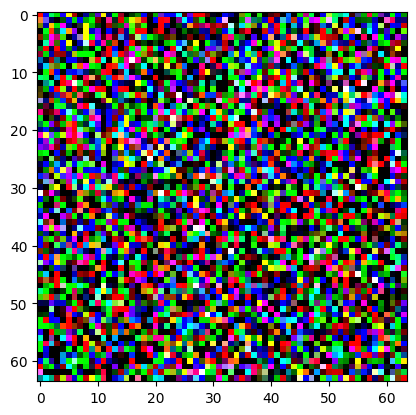

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.931796..3.5841303].


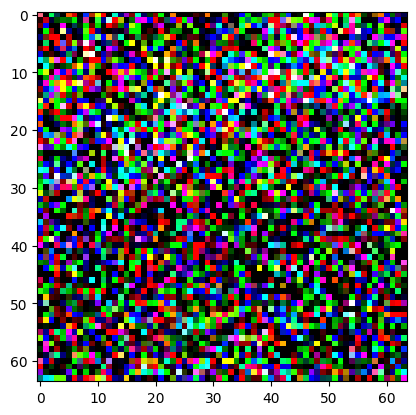

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.059762..3.5563946].


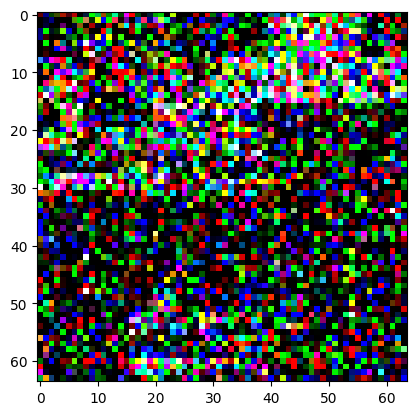

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.565864..3.0650458].


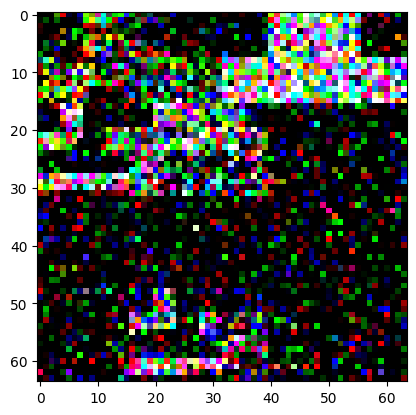

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.376779..2.1745024].


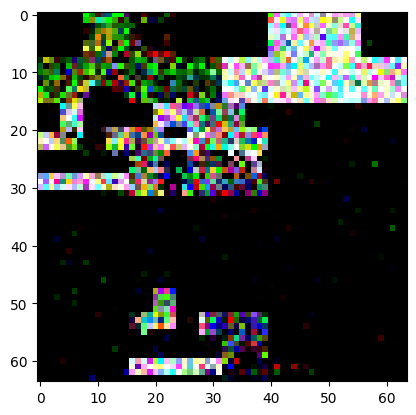

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.018839..1.1137475].


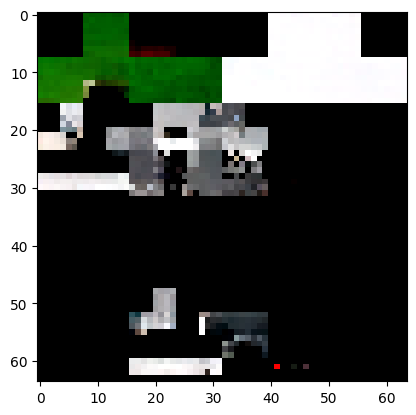

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.018839..1.1137475].


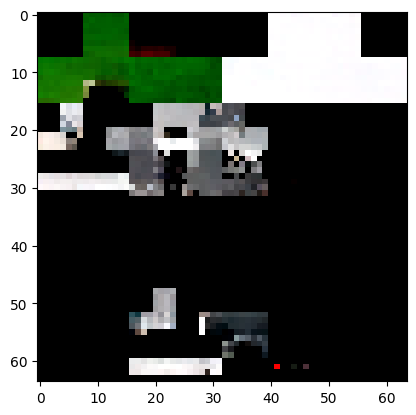

In [46]:
# Sample noise
img = torch.randn((1, 3, 64, 64), device=device)

for i in range(hparams.data['T'])[::-1]:
    t = torch.full((1,), i, device=device).long()
    img = sample_timestep(img, torch.tensor([i]).long().to(device), model)

    if i % 100 == 0:
        npimg = img[0].cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


npimg = img[0].cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()


### Download inference

In [47]:
from PIL import Image
from datetime import datetime

npimg = np.transpose(npimg, (1, 2, 0))

# Add an alpha channel to the image (set to fully opaque)
alpha_channel = np.ones((npimg.shape[0], npimg.shape[1], 1), dtype=npimg.dtype)
npimg = np.concatenate((npimg, alpha_channel), axis=-1)

skin_mask = Image.open("skinmask.png").convert("L")
skin_mask = np.array(skin_mask) / 255.0  # Normalize to range [0, 1]

# Apply the skin mask to the alpha channel
npimg[:, :, 3] *= skin_mask


# Convert the numpy array to an image (scale values to 0-255 and convert to uint8)
image = Image.fromarray(((npimg - npimg.min()) / (npimg.max() - npimg.min()) * 255).astype(np.uint8))

# Save the image to the directory
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
image.save(f"output/output_image_{current_time}.png")